<a target="_blank" href="https://colab.research.google.com/github/vanderbilt-data-science/ai_summer/blob/main/4_1-HF-model-inferencing.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Model Inferencing with Huggingface
> Running already trained models with huggingface.

In this notebook, we'll explore how to get an (already trained) model off of huggingface, and run it as-is on language tasks that we are interested in. We'll do this both with Huggingface's built-in classes, and with the high-level "pipeline" API


## Installations + Imports

Install necessary packages

In [35]:
%%capture
!pip install transformers
!pip install xformers
!pip install accelerate
!pip install timm

Import necessary packages.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import pipeline
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

from huggingface_hub import notebook_login

from PIL import Image
import requests
from io import BytesIO

This will make printing of long strings prettier in Google Colab:

In [37]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

Set up huggingface authorization tokens. Remember, you can find your token on the huggingface website, on your personal [account page](https://huggingface.co/settings/account) under 'Access Tokens'.

In [38]:
!git config --global credential.helper store

In [39]:
notebook_login()

## Simple Inferencing with Huggingface Built-in Classes

We have options for how to load in a model using Huggingface. First, let's choose a model and look at it a bit more closely.

We'll use [gpt2](https://huggingface.co/gpt2) for this example. We can load it in with Huggingface's `GPT2LMHeadModel` class, which knows to expect a gpt2 architecture for the specific model we pass in.

### Load the Model

In [6]:
# 1. Import the necessary libraries. Huggingface has built-in classes for GPT2's architecture and tokenizer.
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# 2. Specify the model. 
# We are using "gpt2". This is the smallest version of the gpt2 model.
# You could change this to "gpt2-medium", "gpt2-large", "gpt2-xl" based on your requirements and system capabilities.
model_name = "gpt2"

# 3. Load the pre-trained model
model = GPT2LMHeadModel.from_pretrained(model_name)

### Tokenizing the Inputs

Huggingface has built-in tokenizers, so we can go ahead and load GPT-2's tokenizer directly.

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

GPT2 was trained to do text completion tasks. So, if we give it a starting portion of text, it will complete that text with something that makes sense. We then must tokenize this input before giving it to the model.

In [8]:
# 1. Define the text that you want the model to extend. 
input_text = " Once upon a time, in a land far away," #9 words, 2 punctuations

# 2. Tokenize the input text and convert to tensor.
input_ids = tokenizer.encode(input_text, return_tensors='pt')

We can view this tokenized text, and see that it is now a series of numbers. In this case, each word in our original text (and punctuation), corresponds to a unique number.

In [9]:
input_ids

tensor([[4874, 2402,  257,  640,   11,  287,  257, 1956, 1290, 1497,   11]])

Remember though, that tokens are not always one word -> one token mapped. Let's look at the tokenization of some compound words to illustrate this.

In [10]:
# 4. Define the text that you want the model to extend. 
input_text_1 = " It's. It is. That's. That is."
input_text_2 = " Firmly. Firm. Enjoyment. Enjoy."

# 5. Tokenize the input text and convert to tensor.
input_ids_1 = tokenizer.encode(input_text_1, return_tensors='pt')
input_ids_2 = tokenizer.encode(input_text_2, return_tensors='pt')

In [11]:
print(input_ids_1)
print(input_ids_2)

tensor([[ 632,  338,   13,  632,  318,   13, 1320,  338,   13, 1320,  318,   13]])
tensor([[31623,   306,    13, 31623,    13, 18179,   434,    13, 18179,    13]])


### Run the Model on the Input

In [12]:
# 6. Generate text based on the input.
# 'max_length' is the maximum length of the generated text. 
# You can change the max_length based on your requirements.
output = model.generate(input_ids, max_length=100, num_return_sequences=1, do_sample=True, pad_token_id=50256)

# 7. Decode the output to readable text.
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

 Once upon a time, in a land far away, in the world where there was the world of myth and magic and truth. Those are the things that define the way we think and do things, which will be reflected back into human experience, for the purpose of making the world that our parents and grandparents taught us.


* * *


What do you make of each of these points? My answer is that all of them can be summarized in some simple words. That, and for


We can see that the output, which is decoded by the tokenizer as well, comes out from the model in a tokenized form.

In [13]:
output[0]

tensor([ 4874,  2402,   257,   640,    11,   287,   257,  1956,  1290,  1497,
           11,   287,   262,   995,   810,   612,   373,   262,   995,   286,
         7918,   290,  5536,   290,  3872,    13,  5845,   389,   262,  1243,
          326,  8160,   262,   835,   356,   892,   290,   466,  1243,    11,
          543,   481,   307, 12548,   736,   656,  1692,  1998,    11,   329,
          262,  4007,   286,  1642,   262,   995,   326,   674,  3397,   290,
        28571,  7817,   514,    13,   628,   198,     9,  1635,  1635,   628,
          198,  2061,   466,   345,   787,   286,  1123,   286,   777,  2173,
           30,  2011,  3280,   318,   326,   477,   286,   606,   460,   307,
        31880,   287,   617,  2829,  2456,    13,  1320,    11,   290,   329])

## Huggingface's `pipeline` Functionality

Huggingface provides a very high-level API called `pipeline` for performing tasks such as text generation, translation, summarization, and more. The `pipeline` functionality allows you to perform this wide range of natural language processing tasks with pre-trained models in just a few lines of code.

Here, we don't need to specify the model we want. Instead, we specify the *task* that we want to complete, and allow huggingface to choose a model that can complete that task for us. It allows you to leverage state-of-the-art models with high efficiency through a unified interface.

Here, we don't even need to specify the model

In [14]:
# Create a text-generation pipeline
text_generator = pipeline(task = "text-generation")

# Provide the beginning of a sentence
input_text = "Once upon a time, in a land far away,"

# Generate text
generated_text = text_generator(input_text, max_length=100, pad_token_id=50256, do_sample=True)[0]['generated_text']

print(generated_text)

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


Once upon a time, in a land far away, there grew up a mighty people, who, following calmly and harmoniously their own life, were endowed with great wisdom. They brought to glory the knowledge of the law of heaven and the law of earth. But they had not taken great pains, and all that they knew contained only a superficial knowledge of the law of the earth. Not only was the knowledge of the law of heaven destroyed without exception, but it was in fact all of them.


And we can see that Huggingface actually defaults to using gpt2 for this task. We could instead, specify this model to the pipleline. We can even specify the model without specifying the task. Let's try it with `gpt-medium`:

In [41]:
# Create a text-generation pipeline
text_generator = pipeline(model="gpt2-medium")

# Provide the beginning of a sentence
input_text = "Once upon a time, in a land far away,"

# Generate text
generated_text = text_generator(input_text, max_length=100, pad_token_id=50256, do_sample=True)[0]['generated_text']

print(generated_text)

Once upon a time, in a land far away, a man in black, armed with two swords, rode away from Pandyas, and was said by others to have reached the desert of Aral. It is written of him that there he killed all that stood upon earth with great violence. To-day the same tradition is expressed; and a man of note from my country says that a thousand years ago, when King Caius was dwelling in Antioch, there happened in one night to


### Pipeline for Other NLP Tasks

The `pipeline` functionality allows us to pick the task we want without having to worry about the model behind it. This means it supports all sorts of NLP tasks!

**Sentiment Analysis**: Use a model like distilbert-base-uncased-finetuned-sst-2-english to predict whether a text is positive or negative.

In [16]:
sentiment_analysis = pipeline("sentiment-analysis")
result = sentiment_analysis("I love this course!")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


label: POSITIVE, with score: 0.9999


**Named Entity Recognition (NER)**: Use a model like dbmdz/bert-large-cased-finetuned-conll03-english to identify named entities in text.

In [17]:
ner_model = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")
result = ner_model("The Eiffel Tower is in Paris")
print(result)

[{'entity': 'I-MISC', 'score': 0.8885886, 'index': 2, 'word': 'E', 'start': 4, 'end': 5}, {'entity': 'I-MISC', 'score': 0.5638956, 'index': 3, 'word': '##iff', 'start': 5, 'end': 8}, {'entity': 'I-MISC', 'score': 0.54671574, 'index': 4, 'word': '##el', 'start': 8, 'end': 10}, {'entity': 'I-LOC', 'score': 0.56473315, 'index': 5, 'word': 'Tower', 'start': 11, 'end': 16}, {'entity': 'I-LOC', 'score': 0.9996275, 'index': 8, 'word': 'Paris', 'start': 23, 'end': 28}]


**Question Answering**: Use a model like distilbert-base-cased-distilled-squad to answer questions based on a given context.

In [18]:
question_answerer = pipeline('question-answering')
context = "The Eiffel Tower is located in Paris"
question = "Where is the Eiffel Tower located?"
result = question_answerer(question=question, context=context)
print(result)

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'score': 0.9879081845283508, 'start': 31, 'end': 36, 'answer': 'Paris'}


**Translation**: Use a model like Helsinki-NLP/opus-mt-en-de to translate English text to German.

In [19]:
translator = pipeline("translation_en_to_de")
result = translator("Hello, how are you?", max_length=40)[0]
print(result['translation_text'])

No model was supplied, defaulted to t5-base and revision 686f1db (https://huggingface.co/t5-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


Hallo, wie sind Sie?


**Summarization**: Use a model like sshleifer/distilbart-cnn-12-6 to generate a summary of a longer text.

In [20]:
summarizer = pipeline("summarization")
ARTICLE = """..."""  # insert a long article here
result = summarizer(ARTICLE, max_length=130, min_length=30, do_sample=False)[0]
print(result['summary_text'])

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


 CNN.com will feature iReporter photos in a weekly Travel Snapshots gallery . Please submit your best shots for next week's gallery of snapshots . Visit CNN iReport.com/Travel next Friday for a new gallery of shots .


### Pipeline for non-NLP tasks

Huggingface, of course, also supports non-NLP tasks. As an example, let's try to do image segmentation below. You'll see that it's just as easy as it was for the NLP tasks!

In [25]:
# URL to the image
image_url = "https://img1.penangpropertytalk.com/wp-content/uploads/2023/05/sri-saujana-apartment-street-view.jpg.jpg"

# Download the image from the URL
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

# Create an image segmentation pipeline using a pre-trained model
image_segmentation = pipeline('image-segmentation')

# Perform image segmentation
segmentation_result = image_segmentation(image)

No model was supplied, defaulted to facebook/detr-resnet-50-panoptic and revision fc15262 (https://huggingface.co/facebook/detr-resnet-50-panoptic).
Using a pipeline without specifying a model name and revision in production is not recommended.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


This "segmentation result" requires a bit of leg work to turn into a segmentation mask, but we can plot it over the original image to see how the model did!

In [34]:
segmentation_result[0:3]

[{'score': 0.97715,
  'label': 'car',
  'mask': <PIL.Image.Image image mode=L size=1200x756 at 0x7FA763427A00>},
 {'score': 0.953412,
  'label': 'car',
  'mask': <PIL.Image.Image image mode=L size=1200x756 at 0x7FA763427B20>},
 {'score': 0.999778,
  'label': 'LABEL_187',
  'mask': <PIL.Image.Image image mode=L size=1200x756 at 0x7FA763250970>}]

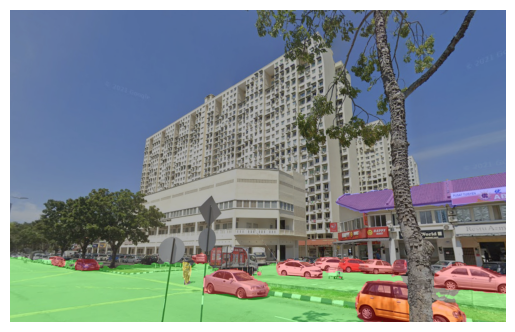

In [40]:
# Create a color map for each class
class_colors = {
    'car': (255, 0, 0),   # Red
    'road': (0, 255, 0),  # Green
    'roof': (0, 0, 255),  # Blue
    'person': (255, 255, 0)  # Yellow
}

# Convert the original image to an RGB array
image_array = np.array(image.convert('RGB'))

# Plot the original image
plt.imshow(image_array)
plt.axis('off')

# Plot the masks
for mask_info in segmentation_result:
    label = mask_info['label']
    mask = np.array(mask_info['mask'])
    color = class_colors.get(label, (0, 0, 0))  # Default color is black
    
    # Apply the mask and color to the image
    image_array[mask > 0] = color

# Display the image with masks
plt.imshow(image_array,alpha=.3)
plt.axis('off')
plt.show()

And many other vision, as well as audio, tasks are supported this way.

Check out the [pipeline documentation](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/pipelines) for more information about what pipelines can do!